<img src="https://5264302.fs1.hubspotusercontent-na1.net/hubfs/5264302/Demo%20Asset%20Resources/CM-Demo-miner_signatures.png" width=1100 margin-left='auto' margin-right='auto'/>

For much of its history, the Bitcoin mining industry has been notoriously opaque. Luckily, it has become a common practice for many BTC mining pools to leave a subtle "miner signature" in each block's coinbase transaction (not to be confused with the popular crypto exchange by the same name). This transaction contains the miner reward— currently 6.25 BTC per block—but also leaves some extra space for arbitrary data, allowing the pool to publicly assert their claim. Using ATLAS v2, we're able to extract this miner signature, enabling us to derive a variety of mining pool metrics.

## Resources
This notebook demonstrates basic functionality offered by the Coin Metrics Python API Client and ATLAS blockchain search engine.

Coin Metrics offers a vast assortment of data for hundreds of cryptoassets. The Python API Client allows for easy access to this data using Python without needing to create your own wrappers using `requests` and other such libraries.

To understand the data that Coin Metrics offers, feel free to peruse the resources below.

- The [Coin Metrics API v4](https://docs.coinmetrics.io/api/v4) website contains the full set of endpoints and data offered by Coin Metrics.
- The [Coin Metrics Product Documentation](https://docs.coinmetrics.io/info) gives detailed, conceptual explanations of the data that Coin Metrics offers.
- The [API Spec](https://coinmetrics.github.io/api-client-python/site/api_client.html) contains a full list of functions.

## Notebook Setup

In [1]:
from os import environ
import sys
import pandas as pd
import numpy as np
import logging
from datetime import date, datetime, timedelta
from coinmetrics.api_client import CoinMetricsClient
import json
import logging
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
from matplotlib import font_manager
import cmasher as cmr
import re
%matplotlib inline
import plotly
from plotly.subplots import make_subplots

In [2]:
logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [3]:
# We recommend privately storing your API key in your local environment.
try:
    api_key = environ["CM_API_KEY"]
    logging.info("Using API key found in environment")
except KeyError:
    api_key = ""
    logging.info("API key not found. Using community client")

client = CoinMetricsClient(api_key)

2024-10-04 13:46:00 INFO     Using API key found in environment


In [4]:
colors = np.unique(cmr.take_cmap_colors('Set3', 15, return_fmt='hex'))
colors

array(['#80B1D3', '#8DD3C7', '#B3DE69', '#BC80BD', '#BEBADA', '#CCEBC5',
       '#D9D9D9', '#FB8072', '#FCCDE5', '#FDB462', '#FFED6F', '#FFFFB3'],
      dtype='<U7')

# ATLAS V2

## Retrieve Block Info

In [5]:
block_info = client.get_list_of_blocks_v2(
    asset='btc',
    start_time=datetime.now()-timedelta(days=365),
    page_size=10000
).parallel(time_increment=timedelta(days=1)).to_dataframe()
block_info['extra_data'] = block_info['extra_data'].astype(str)

Exporting to dataframe type: 100%|██████████| 366/366 [00:06<00:00, 58.56it/s] 


In [6]:
block_info.head()

,block_hash,height,consensus_time,miner_time,n_transactions,n_balance_updates,parent_block_hash,nonce,extra_data,version,difficulty,physical_size,consensus_size,consensus_size_limit
0,00000000000000000003cd8c9919b1073bab32cee67bfb...,810761,2023-10-05 13:54:00+00:00,2023-10-05 15:21:03+00:00,3658,22668,00000000000000000002667c723b1a1f559ed920504ab6...,3789b287,03095f0c1b4d696e656420627920416e74506f6f6c3830...,545259520,57321508229258.039062,1543713,3993396,4000000
1,000000000000000000000d070d5b4fb5c69ee6bae4bab6...,810762,2023-10-05 14:04:54+00:00,2023-10-05 15:26:11+00:00,2689,18732,00000000000000000003cd8c9919b1073bab32cee67bfb...,388afcd5,030a5f0c45022f62696e616e63652f323139fabe6d6d6d...,536993792,57321508229258.039062,1494856,3993547,4000000
2,00000000000000000004090783eb83951d6d9c91dd88f3...,810763,2023-10-05 14:28:43+00:00,2023-10-05 15:33:08+00:00,2528,17306,000000000000000000000d070d5b4fb5c69ee6bae4bab6...,9b7ba148,030b5f0c192f5669614254432f4d696e6564206279207a...,536928256,57321508229258.039062,1422613,3993322,4000000
3,00000000000000000004cd165ee9f93e68460c37173027...,810764,2023-10-05 14:36:46+00:00,2023-10-05 15:40:56+00:00,3227,20335,00000000000000000004090783eb83951d6d9c91dd88f3...,003804fb,030c5f0c194d696e656420627920416e74506f6f6c20f8...,805298176,57321508229258.039062,1572755,3993278,4000000
4,00000000000000000000fb654d8199a1fc240af3bbc173...,810765,2023-10-05 14:57:48+00:00,2023-10-05 15:50:03+00:00,3078,19352,00000000000000000004cd165ee9f93e68460c37173027...,903b489a,030d5f0c2cfabe6d6d0d426074ccdd9e3b0fe208ab9af1...,538968064,57321508229258.039062,1515726,3997698,4000000


In [7]:
# Assign 'empty' to rows where n_transactions == 1
block_info.loc[block_info['n_transactions'] == 1, 'category'] = 'Empty'

# Assign 'not empty' to remaining rows
block_info.loc[block_info['n_transactions'] != 1, 'category'] = 'Not Empty'

In [8]:
block_info['extra_data'][0]

'03095f0c1b4d696e656420627920416e74506f6f6c383036f800c8022ace0b75fabe6d6d7a90b864b377b7d7de125f87ab7890c46a47d58edcd9d602a6758485a2d7a7c2020000000000000026bb0000d455000000000000'

In [9]:
def convert_to_human_readable_ascii(s):
    # Check if the input string is a valid hexadecimal string
    if all(c in '0123456789abcdefABCDEF' for c in s):
        # Convert the input string to bytes
        b = bytes.fromhex(s)
        # Decode the bytes using the ISO-8859-1 encoding
        result = b.decode('ISO-8859-1')
        return result
    else:
        # Return an error message if the input string is not a valid hexadecimal string
        return 'Error: input is not a valid hexadecimal string'

In [10]:
block_info['miner_tag'] = block_info['extra_data'].apply(convert_to_human_readable_ascii)

In [11]:
block_signed = pd.DataFrame(block_info[['miner_tag','height','consensus_time','category']])
block_signed

,miner_tag,height,consensus_time,category
0,\t_ Mined by AntPool806ø È*Î uú¾mmz¸d³w·×Þ...,810761,2023-10-05 13:54:00+00:00,Not Empty
1,\n_ E/binance/219ú¾mmm¡¾¼a04Vy>IC°Jgò ¡Ð0...,810762,2023-10-05 14:04:54+00:00,Not Empty
2," _ /ViaBTC/Mined by z180203/,ú¾mmñÊ1ä¾Ú!³K...",810763,2023-10-05 14:28:43+00:00,Not Empty
3, _ Mined by AntPool ø ¢1ê%-ú¾mm»âHjéZ¾®¨!M...,810764,2023-10-05 14:36:46+00:00,Not Empty
4,"\r_ ,ú¾mm\rB`tÌÝ;â«ñ\tÆ¢èür¹³a\rmá\rÚ...",810765,2023-10-05 14:57:48+00:00,Not Empty
...,...,...,...,...
53385,/\r< OCEAN.XYZ >3OD ã.³Lð\n       ,864146,2024-10-04 15:50:04+00:00,Not Empty
53386,"/\r,ú¾mm ÷$@o È$~¸ÑÆn¹Ô3 ñîõä ¼   ...",864147,2024-10-04 15:51:50+00:00,Not Empty
53387,/\rc  g/Foundry USA Pool #dropgold/+J ½­  ...,864148,2024-10-04 15:56:39+00:00,Not Empty
53388,/\rMined by AntPool èAx®øú¾mm6úq 2iF ...,864149,2024-10-04 15:56:44+00:00,Not Empty


In [12]:
# List of strings included in coinbase signature
miners = ['AntPool', 'ViaBTC', 'binance', 'Binance', 'Foundry', 'Luxor', 
          'SlushPool', 'slush', 'BTC.com','BTC.COM','btc.com','btccom',
          'bitdeer','btcpool', 'F2Pool', 'poolin','xxxxxx.com','CKPool', 
          'BTC.TOP', 'BTCC', 'MARA Pool', 'Mara Pool', 'SpiderPool']

In [13]:
def detect_keywords(df, column, keywords):
    # Create a new column called 'miner'
    df['miner'] = None
    # Iterate over the miner names
    for miner in miners:
        # Use the update method to detect the miner name in the specified column
        # df['miner'].update(df[column].str.extract(rf'({miner})', expand=False))
        df.update({'miner':df[column].str.extract(rf'({miner})', expand=False)})
    # Replace any rows where the 'miner' column is None with 'Unknown'
    df['miner'] = df['miner'].replace({None: 'Other'})
    return df

In [14]:
miners_tagged = detect_keywords(block_signed, 'miner_tag', miners)
miners_tagged = miners_tagged.set_index('consensus_time')
miners_tagged

,miner_tag,height,category,miner
consensus_time,,,,
2023-10-05 13:54:00+00:00,\t_ Mined by AntPool806ø È*Î uú¾mmz¸d³w·×Þ...,810761,Not Empty,AntPool
2023-10-05 14:04:54+00:00,\n_ E/binance/219ú¾mmm¡¾¼a04Vy>IC°Jgò ¡Ð0...,810762,Not Empty,binance
2023-10-05 14:28:43+00:00," _ /ViaBTC/Mined by z180203/,ú¾mmñÊ1ä¾Ú!³K...",810763,Not Empty,ViaBTC
2023-10-05 14:36:46+00:00, _ Mined by AntPool ø ¢1ê%-ú¾mm»âHjéZ¾®¨!M...,810764,Not Empty,AntPool
2023-10-05 14:57:48+00:00,"\r_ ,ú¾mm\rB`tÌÝ;â«ñ\tÆ¢èür¹³a\rmá\rÚ...",810765,Not Empty,F2Pool
...,...,...,...,...
2024-10-04 15:50:04+00:00,/\r< OCEAN.XYZ >3OD ã.³Lð\n       ,864146,Not Empty,Other
2024-10-04 15:51:50+00:00,"/\r,ú¾mm ÷$@o È$~¸ÑÆn¹Ô3 ñîõä ¼   ...",864147,Not Empty,F2Pool
2024-10-04 15:56:39+00:00,/\rc  g/Foundry USA Pool #dropgold/+J ½­  ...,864148,Not Empty,Foundry


In [15]:
def transform_index_to_date(index):
    datetime_index = pd.to_datetime(index)
    date_index = [datetime.date(datetime_obj) for datetime_obj in datetime_index]
    return date_index

In [16]:
date_index = transform_index_to_date(miners_tagged.index)
miners_tagged.index = pd.to_datetime(date_index)

In [17]:
miners_tagged

,miner_tag,height,category,miner
2023-10-05,\t_ Mined by AntPool806ø È*Î uú¾mmz¸d³w·×Þ...,810761,Not Empty,AntPool
2023-10-05,\n_ E/binance/219ú¾mmm¡¾¼a04Vy>IC°Jgò ¡Ð0...,810762,Not Empty,binance
2023-10-05," _ /ViaBTC/Mined by z180203/,ú¾mmñÊ1ä¾Ú!³K...",810763,Not Empty,ViaBTC
2023-10-05, _ Mined by AntPool ø ¢1ê%-ú¾mm»âHjéZ¾®¨!M...,810764,Not Empty,AntPool
2023-10-05,"\r_ ,ú¾mm\rB`tÌÝ;â«ñ\tÆ¢èür¹³a\rmá\rÚ...",810765,Not Empty,F2Pool
...,...,...,...,...
2024-10-04,/\r< OCEAN.XYZ >3OD ã.³Lð\n       ,864146,Not Empty,Other
2024-10-04,"/\r,ú¾mm ÷$@o È$~¸ÑÆn¹Ô3 ñîõä ¼   ...",864147,Not Empty,F2Pool
2024-10-04,/\rc  g/Foundry USA Pool #dropgold/+J ½­  ...,864148,Not Empty,Foundry
2024-10-04,/\rMined by AntPool èAx®øú¾mm6úq 2iF ...,864149,Not Empty,AntPool


In [18]:
other_miners = miners_tagged.loc[miners_tagged['miner'] == 'Other']
other_miners

,miner_tag,height,category,miner
2023-10-05," _ F°,ñ¿    /NiceHash/",810784,Not Empty,Other
2023-10-06,¬_ /ultimus/783p ? DòuÄú¾mm(0³4yï@×ì7HWlù»...,810924,Not Empty,Other
2023-10-06,Ë_  \t\t\t \t\t \t_ [    ,810955,Not Empty,Other
2023-10-06,"Ö_ /ultimus/787p \ÏD­ú¾mmàÀ.,±r}?^º¿rE¨æ...",810966,Not Empty,Other
2023-10-07,` w !e/SBICrypto.com Pool/ø³bS     ,811027,Not Empty,Other
...,...,...,...,...
2024-10-03,/\rMined by SecPool )Õ ­ú¾mmÑÀ)Ñgò2e...,864005,Not Empty,Other
2024-10-03,"/\rMined by SecPool 9ÕuRíú¾mm(5L,±kÏä½...",864006,Not Empty,Other
2024-10-04,C/\r \t\t\t \t\t \tÉ  \n   ,864067,Not Empty,Other
2024-10-04,l/\rdÏÿf/SBICrypto.com Pool/\r$²v      ,864108,Not Empty,Other


In [19]:
miners_tagged['miner'] = miners_tagged['miner'].replace('xxxxxx.com', 'Poolin')
miners_tagged['miner'] = miners_tagged['miner'].replace('poolin', 'Poolin')
miners_tagged['miner'] = miners_tagged['miner'].replace('btccom', 'BTC.com')
miners_tagged['miner'] = miners_tagged['miner'].replace('btc.com', 'BTC.com')
miners_tagged['miner'] = miners_tagged['miner'].replace('btcpool', 'BTC.com')
miners_tagged['miner'] = miners_tagged['miner'].replace('bitdeer', 'BTC.com')
miners_tagged['miner'] = miners_tagged['miner'].replace('slush', 'Braiins Pool')
miners_tagged['miner'] = miners_tagged['miner'].replace('binance', 'Binance Pool')
miners_tagged['miner'] = miners_tagged['miner'].replace('Binance', 'Binance Pool')
miners_tagged['miner'] = miners_tagged['miner'].replace('Mara Pool', 'MARA Pool')

In [20]:
# Group the data by the date and calculate the relative proportions of each category
data = miners_tagged.groupby(miners_tagged.index.date)['miner'].value_counts(normalize=True)
data = data.unstack()

averages = data.sum()
averages = pd.DataFrame(averages.sort_values(ascending=False))
averages = averages.index.tolist()
data = data[averages]

In [21]:
data

miner,Foundry,AntPool,ViaBTC,F2Pool,Other,Binance Pool,MARA Pool,Luxor,SpiderPool,Braiins Pool,BTC.com,Poolin
2023-10-05,0.178571,0.303571,0.160714,0.160714,0.017857,0.125000,0.017857,0.035714,NaN,NaN,NaN,NaN
2023-10-06,0.237500,0.256250,0.112500,0.143750,0.018750,0.081250,0.062500,0.043750,NaN,0.006250,0.012500,0.025000
2023-10-07,0.263158,0.280702,0.087719,0.122807,0.046784,0.046784,0.040936,0.035088,NaN,0.011696,0.046784,0.017544
2023-10-08,0.310811,0.250000,0.121622,0.108108,0.033784,0.067568,0.027027,0.027027,NaN,0.033784,0.013514,0.006757
2023-10-09,0.269231,0.250000,0.115385,0.115385,0.038462,0.108974,0.038462,0.019231,NaN,0.012821,0.019231,0.012821
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,0.357664,0.255474,0.065693,0.131387,0.058394,0.021898,0.021898,0.007299,0.058394,0.007299,NaN,0.014599
2024-10-01,0.324841,0.305732,0.133758,0.095541,0.057325,0.012739,0.019108,0.019108,0.006369,0.025478,NaN,NaN
2024-10-02,0.270968,0.219355,0.174194,0.083871,0.064516,0.032258,0.064516,0.025806,0.032258,0.012903,0.012903,0.006452
2024-10-03,0.234177,0.316456,0.101266,0.107595,0.082278,0.037975,0.037975,0.012658,0.031646,0.025316,0.012658,NaN


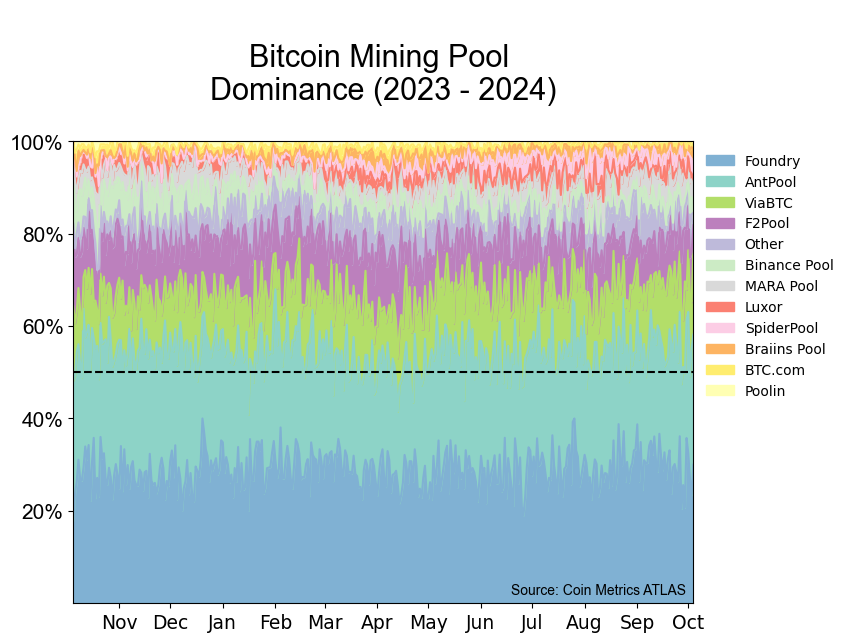

In [22]:
# Plot the data as an area chart
ax = data.plot.area(figsize=(8, 6),fontsize=13.5,color=colors)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_title('\nBitcoin Mining Pool \nDominance (2023 - 2024)\n',fontsize=22,fontdict={'font':'arial'})
ax.axhline(0.5, linestyle='--', color='black')
plt.xlim([miners_tagged.index[0],miners_tagged.index[-1]])
plt.ylim(0,1)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ['20%','40%','60%','80%','100%'],fontdict={'font':'arial','size':15})
plt.legend(bbox_to_anchor=(1,1),frameon=False)
plt.annotate('Source: Coin Metrics ATLAS',weight='book',font='arial',xy=(1.001, 0.001), xycoords='axes fraction',color='black',xytext=(-8, 6), textcoords='offset pixels',horizontalalignment='right',verticalalignment='bottom')
plt.savefig('./Pool-Dominance.png',facecolor='white',dpi=100)
plt.show()

In [23]:
total_blocks = pd.DataFrame(miners_tagged.index.value_counts())
total_blocks.rename(columns={total_blocks.columns[0]: 'Total Blocks'}, inplace=True)
total_blocks

,Total Blocks
2024-02-02,188
2024-01-25,181
2024-03-07,180
2024-07-22,179
2024-02-12,179
...,...
2024-01-15,114
2024-06-23,112
2024-10-04,110
2024-09-11,108


In [24]:
empty_blocks = miners_tagged.groupby([miners_tagged.index.date,miners_tagged.miner])['category'].value_counts()
empty_blocks = empty_blocks.unstack()

In [25]:
empty_blocks = pd.DataFrame(empty_blocks.reset_index()).fillna(0).set_index('level_0')
empty_blocks

category,miner,Empty,Not Empty
level_0,,,
2023-10-05,AntPool,0.0,17.0
2023-10-05,Binance Pool,0.0,7.0
2023-10-05,F2Pool,1.0,8.0
2023-10-05,Foundry,0.0,10.0
2023-10-05,Luxor,0.0,2.0
...,...,...,...
2024-10-04,Luxor,0.0,4.0
2024-10-04,MARA Pool,0.0,1.0
2024-10-04,Other,0.0,3.0


In [26]:
df_pivot = empty_blocks.pivot_table(index=empty_blocks.index, columns="miner", values="Empty")
df_pivot = df_pivot.join(total_blocks[['Total Blocks']])
df_pivot = df_pivot.fillna(0)
df_pivot

,AntPool,BTC.com,Binance Pool,Braiins Pool,F2Pool,Foundry,Luxor,MARA Pool,Other,Poolin,SpiderPool,ViaBTC,Total Blocks
level_0,,,,,,,,,,,,,
2023-10-05,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56
2023-10-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160
2023-10-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,171
2023-10-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148
2023-10-09,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137
2024-10-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,157
2024-10-02,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,155


In [27]:
df_empty = df_pivot.iloc[:,0:].div(df_pivot['Total Blocks'], axis=0)
df_empty = df_empty.drop(df_empty.columns[-1:], axis=1)

In [28]:
df_empty = df_empty[averages]
df_empty

,Foundry,AntPool,ViaBTC,F2Pool,Other,Binance Pool,MARA Pool,Luxor,SpiderPool,Braiins Pool,BTC.com,Poolin
level_0,,,,,,,,,,,,
2023-10-05,0.0,0.000000,0.0,0.017857,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2023-10-06,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2023-10-07,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2023-10-08,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2023-10-09,0.0,0.006410,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-30,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2024-10-01,0.0,0.006369,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
2024-10-02,0.0,0.006452,0.0,0.000000,0.0,0.0,0.0,0.006452,0.006452,0.0,0.0,0.0


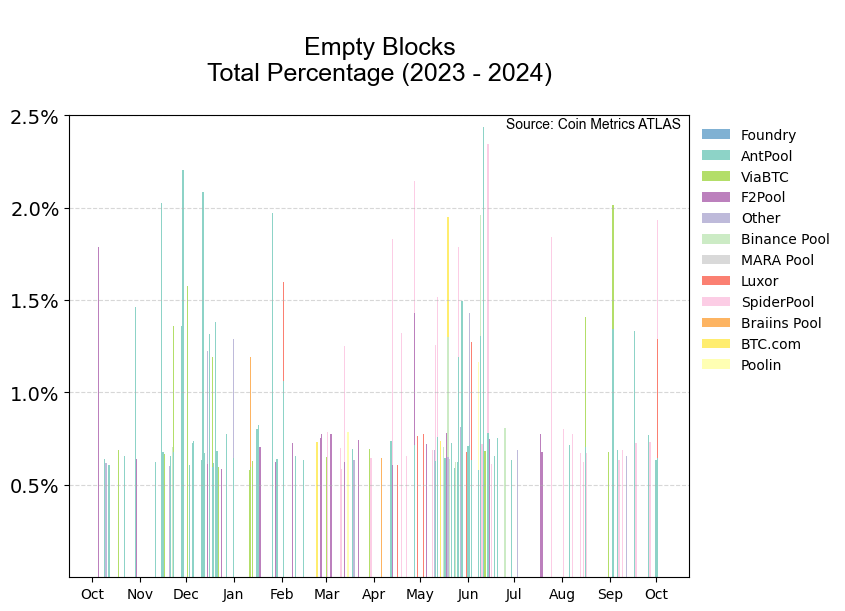

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
cumval = 0
i = 0
for col in df_empty.columns:
    plt.bar(df_empty.index, df_empty[col], bottom=cumval, label=col, color=colors[i])
    cumval = cumval+df_empty[col]
    i += 1
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.title('\nEmpty Blocks\nTotal Percentage (2023 - 2024)\n', fontdict = {'size':18, 'font': 'arial'})
plt.xticks(rotation=0)
plt.xlabel('')
plt.legend(bbox_to_anchor=(1,1),frameon=False)
plt.yticks([0.005, 0.010, 0.015, 0.02, 0.025], ['0.5%','1.0%','1.5%','2.0%','2.5%'],fontdict={'size':14})
plt.grid(True, axis='y',linestyle='--',alpha=0.5)
plt.annotate('Source: Coin Metrics ATLAS',weight='book',font='arial',xy=(1.00, 0.953), xycoords='axes fraction',color='black',xytext=(-8, 6), textcoords='offset pixels',horizontalalignment='right',verticalalignment='bottom')
plt.savefig('./Empty-Blocks-Total-2023-2024.png',facecolor='white',dpi=100)
plt.xlabel('');

In [30]:
empty_blocks_total = pd.DataFrame(miners_tagged.groupby([miners_tagged.miner])['category'].value_counts(normalize=True))
empty_blocks_total = empty_blocks_total.unstack().fillna(0)
empty_blocks_total.columns = empty_blocks_total.columns.droplevel(0)
empty_blocks_total = empty_blocks_total.reindex(averages)
empty_blocks_total

category,Empty,Not Empty
miner,,
Foundry,0.000000,1.000000
AntPool,0.005885,0.994115
ViaBTC,0.002395,0.997605
F2Pool,0.003208,0.996792
Other,0.003595,0.996405
Binance Pool,0.002993,0.997007
MARA Pool,0.000000,1.000000
Luxor,0.005000,0.995000
SpiderPool,0.035996,0.964004


In [31]:
pool_total_blocks = pd.DataFrame(miners_tagged['miner'].value_counts())
pool_total_blocks = pool_total_blocks.drop('Other')
pool_total_blocks.rename(columns={pool_total_blocks.columns[0]: 'Total Blocks Mined'}, inplace=True)
pool_total_blocks

,Total Blocks Mined
miner,
Foundry,15492
AntPool,13595
ViaBTC,6680
F2Pool,5923
Binance Pool,2339
MARA Pool,1986
Luxor,1400
SpiderPool,889
Braiins Pool,858


In [32]:
row_num = empty_blocks_total.index.get_loc('Other')
colors_no_other = np.delete(colors, row_num)
empty_blocks_total = empty_blocks_total.drop('Other')

In [33]:
pool_total_blocks.reset_index()

,miner,Total Blocks Mined
0,Foundry,15492
1,AntPool,13595
2,ViaBTC,6680
3,F2Pool,5923
4,Binance Pool,2339
5,MARA Pool,1986
6,Luxor,1400
7,SpiderPool,889
8,Braiins Pool,858
9,BTC.com,737


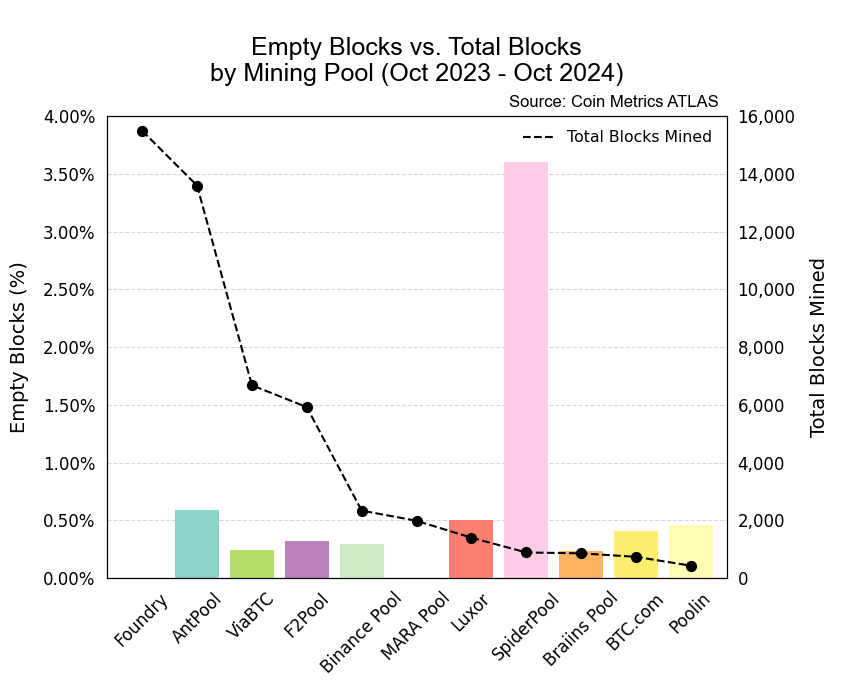

In [34]:
ax = empty_blocks_total['Empty'].plot.bar(figsize=(8, 6),stacked=True,fontsize=12,color=colors_no_other,width=0.8,zorder=2)
def format_percent(x, pos):
    return '{:.2%}'.format(x)
formatter = FuncFormatter(format_percent)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(rotation=45,size=12)
plt.yticks(rotation=0,size=12)
plt.title('\nEmpty Blocks vs. Total Blocks\nby Mining Pool (Oct 2023 - Oct 2024)\n', fontdict = {'size':18, 'font': 'arial'})
plt.xlabel('');
plt.ylabel('Empty Blocks (%)',fontsize=14,labelpad=10);
plt.tick_params(axis='both', which='both', length=0, pad=8)
plt.ylim(0,0.04)
ax.grid(True, axis='y',linestyle='--',zorder=1,alpha=0.5)
ax2 = ax.twinx()
pool_total_blocks.plot.line(ax=ax2,color='black',linestyle='--',legend=True)
pool_total_blocks.reset_index().plot.scatter(x='miner',y='Total Blocks Mined',ax=ax2,color='black', s=50)
ax2.set_yticks([0,2000,4000,6000,8000,10000,12000,14000,16000])
plt.ylim(0,16000)
ax2.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
plt.legend(bbox_to_anchor=(1,1.0),frameon=False,fontsize=11.3)
plt.tick_params(axis='both', which='both', length=0, pad=8)
plt.yticks(rotation=0,size=12)
plt.ylabel('Total Blocks Mined\n',fontsize=14,labelpad=10);
plt.annotate(
    'Source: Coin Metrics ATLAS',
    weight='book',
    font='arial',
    fontsize=12,
    xy=(1.0, 1.0),
    xycoords='axes fraction',
    color='black',
    xytext=(-8, 6),
    textcoords='offset pixels',
    horizontalalignment='right',
    verticalalignment='bottom'
)
plt.savefig('./Empty-Blocks-by-Pool.png',facecolor='white',dpi=100)